In this notebook file, I perform data exploration and cleaning for the kickstarter classification. Through this, I mainly rely on `pandas` and `sklearn` for data exploration and pre-processing. I utilize `matplotlib`, `seaborn` packages for data visualization.

The data exploration here is broken to the following steps:
 1. Set-up dependencies
 2. Load data
 3. Explore data structure
 4. Check on missing values
 5. Check on duplicate rows
 6. Parse datetime variables 
 7. Check on outliers
 8. Encode categorical variables
 10. Save data

## 1. Set-up Dependencies
First things first, I import all dependencies and set up the current and the project directories:

In [1]:
 %matplotlib inline
import os, inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# get path to current and root directories
CURR_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURR_DIR)

/home/aidin/miniconda3/envs/kickstarter/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## 2. Load data
I load data to a pandas data frame with `read_csv` method and name it `df` :

In [2]:
fname = os.path.join(ROOT_DIR, "kickstarter", "data", "raw", "data.csv")
df = pd.read_csv(fname)

I make a deep copy of the data frame first. This allows me to modify data freely while I always have the original data for further reference.

In [3]:
df_raw = df.copy(deep=True)

## 3. Explore data structure
Once the data has been loaded, I look at the basic structure of the data using the `head()` method to print out the first five rows. I also print out the column names, the shape and the data types. By this, I can get a general idea of the structure of data and data columns.

In [4]:
print("-"*30 + " columns " + "-"*30 + os.linesep)
print(repr(df.columns))
print("-"*30 + " shap e" + "-"*30 + os.linesep)
print(df.shape)
print("-"*30 + " data types " + "-"*30 + os.linesep)
print(df.dtypes)
print("-"*30 + " top 5 rows " + "-"*30 + os.linesep)
df.head()

------------------------------ columns ------------------------------

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')
------------------------------ shap e------------------------------

(378661, 15)
------------------------------ data types ------------------------------

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object
------------------------------ top 5 rows ------------------------------



,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Here, I can see  that the kickstarter data frame has 15 columns. All the column labels are in lowercase which is the way I usually prefer to work with. There are no redundant columns and everything looks fine.
Moreover, I see the data frame includes several categorical variables that can have connections to the target prediction variable (state). I might consider encoding of the categorical variables into numeric variables.

Let's look at the unique values of each categorical variables:

In [5]:
for column in ["main_category", "category", "currency", "country", "state"]:
    print(f"{column} labels:  ", repr(df[column].unique()))

main_category labels:   array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)
category labels:   array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Childrenswear', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Accessories', 'Rock', 'Hardware',
       'Software', 'Weaving', 'Gadgets', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop'

Here, the results show that the target `state` column include 6 unique values while the current objective of the project only concerns with the success-failure classification of kickstarters. To adapt the data to this specific problem, I take out data rows with states labeled as `canceled`, `live`, `undefined` and `suspended`. This results in a subset of kickstarter data that only includes `failed` and `successful` labels.

In [6]:
df = df.loc[df.state.isin(["failed", "successful"])]

To avoid blank space in the column label I rename `usd pledged` to `usd_pledged`:

In [7]:
df.rename(index=str, columns={"usd pledged": "usd_pledged"}, inplace=True)

## 4. Check on missing values

Now that I have generated some basic information about the data, I take a deeper look into the issues that data might pose and perform data cleaning if needed.

I start off by investigating for missing values. The missing (null) values is one of the most common issue with raw data wherein the pandas terminology are basically referred by NaN values. The missing values can be related to when an entry in data is not filled properly, the data entry is not available or there is a computational error. I look at NaN values in pandas data frame by `isnull()` method:

In [8]:
n_rows_with_nan = df.isnull().sum()
n_rows_with_nan

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd_pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

Let's compute what percentage of columns contain NaN values:

In [9]:
n_rows = df.shape[0]
nan_percentage = n_rows_with_nan.values / n_rows * 100

nan_percentage

array([0.        , 0.0009045 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06331499, 0.        , 0.        ])

This shows that the `name` and `usd_pledged` are the only columns that contain null values. Knowing that there exist two separate columns for real used pledged amounts, `usd_pledged` and `used_pledged_real`, the column with missing values can easily be discarded. In the case of the `name` column, hopefully, there are not many missing values included. So, I assume that the dropping rows with null values will not heavily affect the end performance of the modeling. Moving forward, I drop the whole `used_pledged_real` column and any rows with `null` values:

In [10]:
df.dropna(axis=0, how="any", subset=["name"], inplace=True)
df.drop(axis=1, columns=["usd_pledged"], inplace=True)
df.isnull().values.any()

False

## 5. Check on duplicate rows

In the next step, I check on the `id`s or `names` columns for duplicate rows. By this, I will try to discard redundant data records.

In [11]:
n_rows_with_duplicates = df.duplicated(subset=["ID", "name"])
n_rows_with_duplicates.any()

False

There are no duplicate rows in the data frame.

## 6. Parse datetime variables

The `deadline` and `launched` columns that describe temporal stamps in the data have string `object` type values. Let's cast these two columns to pandas `datatime64` object. Casting temporal values as `datatime64` object is a quite efficient when decomposing temporal data-time data to sub-temporal stamps e.g. getting day, month or year from a 'month/day/year' object. This avoids any string-like processing and is useful when one wants to generate relative time data from absolute time stamps. Dropping the time component of date-time inputs, the following converts the `deadline` and `launched` columns as `datetime64`:

In [12]:
df.deadline = pd.to_datetime(df.deadline, format="%Y-%m-%d")
df.launched = pd.DataFrame(pd.to_datetime(df.launched, format="%Y-%m-%d"))
df.deadline = pd.to_datetime(df.deadline.dt.date)
df.launched = pd.to_datetime(df.launched.dt.date)
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

As another observation, both `launced` and `deadline` columns in the raw data only relate to absolute temporal values, recorded daily. I suppose that daily temporal resolution here could not correlate well to the Kickstarter state prediction problem. To deal with this issue, I add up a delta time variable that encodes the duration of kickstarters. Given that the type of time stamps has been casted to `datetime64`, the kickstarter duration can be easily obtained as follows:

In [13]:
df["duration"] = (df.deadline - df.launched)
df.duration = df.duration.dt.days.astype("float32")

Moreover, I suspect that kickstarter events are more often monthly or seasonal. That is, the season or the month when a kickstarter project starts that can have connections to its success or failure. Per this hypothesis, It is worthy to also consider seasonal and monthly components of `laucned` timestamps into the classification problem. So, let's generate two separate `quarter` and `month` columns that encode kickstarters launch events:

In [14]:
df["month"] = df.launched.dt.month.astype("float32")
df["quarter"] = df.launched.dt.quarter.astype("float32")
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,month,quarter
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59.0,8.0,3.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60.0,9.0,3.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45.0,1.0,1.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30.0,3.0,1.0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,50000.00,35.0,2.0,1.0


## 7. Check on outliers
Having the data formated, let's look at the possible outliers. I analyze the outliers through extreme value analsis via scatter plots and box plots of the continuous variables:

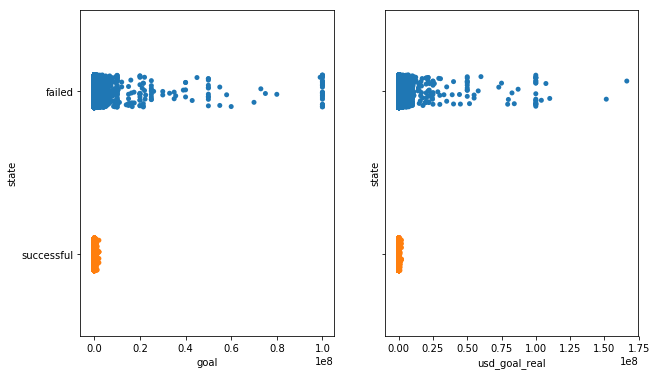

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,6), sharey=True)
_ = sns.stripplot(y="state", x="goal", data=df, ax=axes[0], orient="h")
_ = sns.stripplot(y="state", x="usd_goal_real", data=df, ax=axes[1], orient="h")

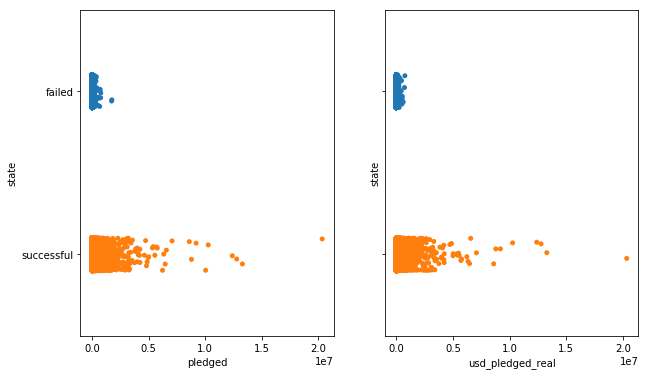

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10,6), sharey=True)
_ = sns.stripplot(y="state", x="pledged", data=df, ax=axes[0], orient="h")
_ = sns.stripplot(y="state", x="usd_pledged_real", data=df, ax=axes[1], orient="h")

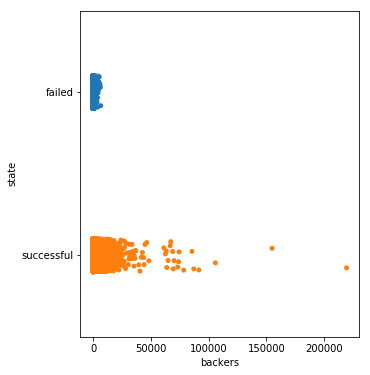

In [17]:
fig, axes = plt.subplots(ncols=1, figsize=(5,6), sharey=True)
_ = sns.stripplot(y="state", x="backers", data=df, ax=axes, orient="h")

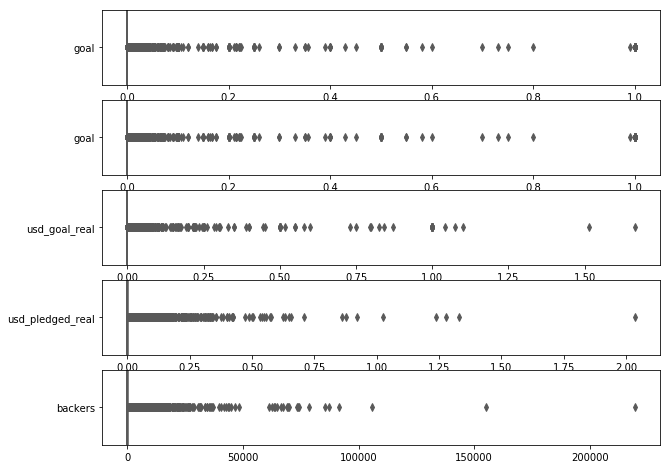

In [18]:
fig, ax = plt.subplots(nrows=(5), figsize=(10,8))
sns.boxplot(data = df[["goal"]]
            ,orient="h",
            palette="Set2",
            width=200,
            ax=ax[0])
sns.boxplot(data = df[["goal"]]
            ,orient="h",
            palette="Set2",
            width=200,
            ax=ax[1])
sns.boxplot(data = df[["usd_goal_real"]]
            ,orient="h",
            palette="Set2",
            width=200,
            ax=ax[2])
sns.boxplot(data = df[["usd_pledged_real"]]
            ,orient="h",
            palette="Set2",
            width=200,
            ax=ax[3])
sns.boxplot(data = df[["backers"]]
            ,orient="h",
            palette="Set2",
            width=200,
            ax=ax[4])

One can see here that several points exist beyond the upper extreme ranges. This suggests, there are significant amont of outliers and could have have negative effects on the performance of classfication. Not explicitly removing outliers, I will try to address this issue by `sckikt-learn` robust scaler whilde doing data normalization.

## 8. Encode categorical variables
There are 5 variables in the data with categorical values: `category`, `main_category`, `currency`, `country` and `state`. To be able to integrate these variables into the classification problem, they need to be encoded into numerical values. This can be easily achieved by label encoding. I use the Scikit-Learn `LabelEncoder` for label encoding.

In [19]:
label_encoder = LabelEncoder()
df["category_code"] = label_encoder.fit_transform(df.category).astype("float32")
df["main_category_code"] = label_encoder.fit_transform(df.main_category).astype("float32")
df["country_code"] = label_encoder.fit_transform(df.country).astype("float32")
df["state_code"] = label_encoder.fit_transform(df.state)

## 9. Drop redundant variables
Lstly, I drop the rendundant columns and cast all data variables as `float`.

In [20]:
df.drop(axis=1, columns=[
    "ID",
    "name",
    "launched",
    "deadline",
    "currency",
    "category", 
    "main_category",
    "country", 
    "state"
], inplace=True)
df.backers = df.backers.astype("float32")

## 10. Save clean data
Reset the index and save the processed data frame as `csv`:

In [21]:
df.reset_index(inplace=True)
fname = os.path.join(ROOT_DIR, "kickstarter", "data", "ext", "data_clean.csv")
df.to_csv(fname)

In [22]:
df.dtypes

index                  object
goal                  float64
pledged               float64
backers               float32
usd_pledged_real      float64
usd_goal_real         float64
duration              float32
month                 float32
quarter               float32
category_code         float32
main_category_code    float32
country_code          float32
state_code              int64
dtype: object

In [23]:
df.head()

,index,goal,pledged,backers,usd_pledged_real,usd_goal_real,duration,month,quarter,category_code,main_category_code,country_code,state_code
0,0,1000.0,0.0,0.0,0.0,1533.95,59.0,8.0,3.0,108.0,12.0,9.0,0
1,1,30000.0,2421.0,15.0,2421.0,30000.00,60.0,9.0,3.0,93.0,6.0,22.0,0
2,2,45000.0,220.0,3.0,220.0,45000.00,45.0,1.0,1.0,93.0,6.0,22.0,0
3,3,5000.0,1.0,1.0,1.0,5000.00,30.0,3.0,1.0,90.0,10.0,22.0,0
4,5,50000.0,52375.0,224.0,52375.0,50000.00,35.0,2.0,1.0,123.0,7.0,22.0,1


In [24]:
df.state_code.unique()

array([0, 1])